# Global Analysis Pipeline

## Imports

In [619]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import math
pd.set_option('display.max_columns', None)

## Global variables / settings for this notebook

In [620]:
# subject-independant directory and filename of raw-data
input_subject_folder = f"..\\data\\preprocessed\\"
# path to stimuli of experiment
exp_stimuli_folder = "..\\stimuli\\"
# set global colormap var
cmp = plt.cm.viridis_r
# display resolution
display = {"width": 1920, "height": 1080}
# Define the folder name
plt_folder_name = f'..\\plots\\global'# Define the global folder name

In [621]:
# enter subject id of participants you want to include in the global analysis 
global_analysis_subjects = [3, 7, 9, 2, 4, 6, 10]

In [622]:
subj_list = []
for subj in global_analysis_subjects:
    subj_list.append(f"subject-{subj}.tsv")


dframes_list = []
for filename in subj_list:
    df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
    dframes_list.append(df)

data = pd.concat(dframes_list, axis=0, ignore_index=True)

# clean up sentence_id
for index, value in data['SENTENCE_ID'].items():
    if pd.notna(value):
        if type(value) == float:
            data.at[index, "SENTENCE_ID"] = str(int(data.at[index, "SENTENCE_ID"]))
        elif ".0" in value:
            data.at[index, "SENTENCE_ID"] = str(data.at[index, "SENTENCE_ID"].split('.')[0])
for index, value in data['SUBJECT'].items():
    if pd.notna(value):
        if type(value) == float:
            data.at[index, "SUBJECT"] = str(int(data.at[index, "SUBJECT"]))
        elif ".0" in value:
            data.at[index, "SUBJECT"] = str(data.at[index, "SUBJECT"].split('.')[0])

C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_22628\1798379293.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_22628\1798379293.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_22628\1798379293.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_22628\1798379293.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
C:\Users\CleresA

In [624]:
def bpog_in_target_bbox(bpogx, bpogy, pos):

    width = display["width"]
    height = display["height"]

    x = bpogx * width
    y = bpogy * height
    
    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200

    if (x > pos_x_l) and (x < pos_x_r):
        if(y > pos_y_d) and (y < pos_y_u):
            return True

    return False


def get_bounding_box_coords(pos):
    
    relpos = 0    
    width = display["width"]
    height = display["height"]


    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200
    
    return (pos_x_l, pos_x_r, pos_y_d, pos_y_u)

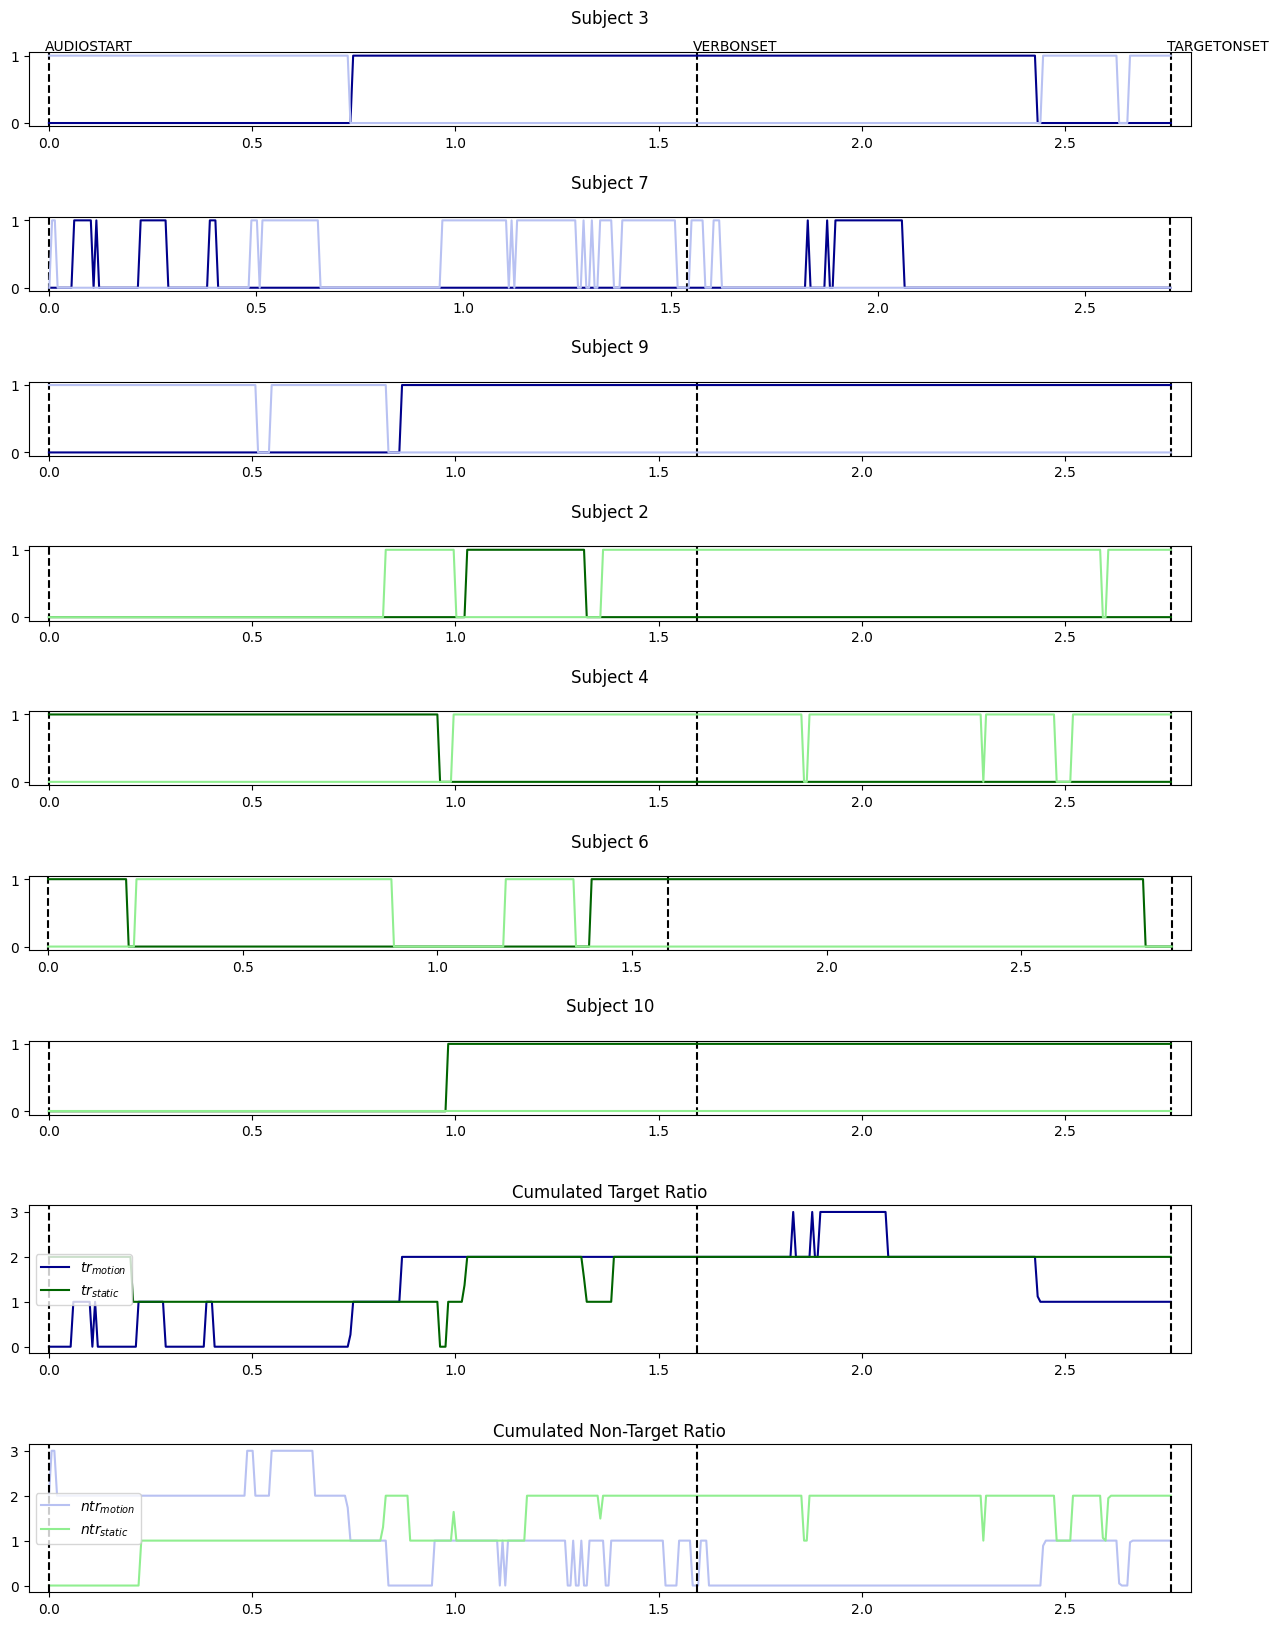

In [643]:
def calc_tr_ntr(data, highlight, sentence_id):

    # init variables
    ratios = [1] * len(global_analysis_subjects)
    ratios.append(2)
    ratios.append(2)

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    data_subset = data_subset.reset_index(drop=True)
    
    # get first row of dataframe
    first_row = data_subset.iloc[0]

    # get general information
    stc = first_row["SENTENCE"]
    t_pos = first_row["TARGET_POS"]
    
    # determin other AOIs
    all_t_pos = ["TL", "TR", "BL", "BR"]
    all_t_pos.remove(t_pos)

    # set tr/ntr for each row
    for index, row in data_subset.iterrows():

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        in_b_box_other = bpog_in_target_bbox(x, y, all_t_pos[0]) or bpog_in_target_bbox(x, y,  all_t_pos[1]) or bpog_in_target_bbox(x, y,  all_t_pos[2])
        
        if in_b_box:
            data_subset.at[index, "TR"] = int(1)
            data_subset.at[index, "NTR"] = int(0)
        else:
            data_subset.at[index, "TR"] = int(0)
            if in_b_box_other:
                data_subset.at[index, "NTR"] = int(1)
            else:
                data_subset.at[index, "NTR"] = int(0)

    # fig 
    fig, ax = plt.subplots(len(global_analysis_subjects)+2, 1, figsize=(15, 20), height_ratios=ratios)
    fig.subplots_adjust(hspace=1)
    
    # subplots
    li = len(global_analysis_subjects)
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=='{subj_no}'")
        subj_condition = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()

        subj_audiostart = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
        subj_verbonset = subj_data.query(f"EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        subj_targetonset = subj_data.query(f"EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        
        # normalize time for each subject
        for index, row in subj_data.iterrows():
            subj_data.at[index, "TIME"] -= subj_audiostart
            data_subset.at[index, "TIME"] -= subj_audiostart

        # plot subplots for each participant
        ax[i].set_title(f"Subject {subj_no}\n")
        
        ax[i].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (subj_targetonset * 150).round(0).astype(int)
        time = np.linspace(0, subj_targetonset, num=lin_num)

        temdf = pd.DataFrame({})
        temdf['TIME'] = time
        temdf['TR'] = interp_func_tr(time).round(0).astype(int)
        temdf['NTR'] = interp_func_ntr(time).round(0).astype(int)
        
        ax[i].plot(temdf["TIME"], temdf["TR"], label=f"$tr_{subj_condition[0]}$", color = "darkgreen" if subj_condition == "static" else "darkblue")
        ax[i].plot(temdf["TIME"], temdf["NTR"], label=f"$ntr_{subj_condition[0]}$", color = "lightgreen" if subj_condition == "static" else "#b8c1f2")

        ax[i].set_xlim((-.05, subj_targetonset+.05))
    
    # text cuenames
    ax[0].text(-0.01, 1.08, 'AUDIOSTART', color = 'grey' if 'a' in highlight else 'k')
    ax[0].text(subj_verbonset-0.01, 1.08, 'VERBONSET', color = 'grey' if 'v' in highlight else 'k')
    ax[0].text(subj_targetonset-0.01, 1.08, 'TARGETONSET', color = 'grey' if 't' in highlight else 'k')

    # final dfs
    static = pd.DataFrame({})
    motion = pd.DataFrame({})
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=='{subj_no}'").copy()
        subj_condition = subj_data.sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()
        end = subj_data.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (end * 150).round(0).astype(int)

        time = np.linspace(0, end, num=lin_num)

        if subj_condition == "motion":
            
            if motion.empty:
                motion['TIME'] = time
                motion['TR'] = interp_func_tr(time)
                motion['NTR'] = interp_func_ntr(time)
            else:
                for index, row in motion.iterrows():
                    motion.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    motion.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)
        
        elif subj_condition == "static":

            if static.empty:
                static['TIME'] = time
                static['TR'] = interp_func_tr(time)
                static['NTR'] = interp_func_ntr(time)
            else:
                for index, row in static.iterrows():
                    static.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    static.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)

    
    # cummulated plot tr
    ax[li].set_title(f"Cumulated Target Ratio")
    
    ax[li].plot(motion["TIME"], motion["TR"], label="$tr_{motion}$", color = "darkblue")
    ax[li].plot(static["TIME"], static["TR"], label="$tr_{static}$", color = "darkgreen")
    
    ax[li].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].set_xlim((-.05, subj_targetonset+.05))
    ax[li].legend(loc="center left")
    
    # cummulated plot ntr
    ax[li+1].set_title(f"Cumulated Non-Target Ratio")
    
    ax[li+1].plot(motion["TIME"], motion["NTR"], label="$ntr_{motion}$", color = "#b8c1f2")
    ax[li+1].plot(static["TIME"], static["NTR"], label="$ntr_{static}$", color = "lightgreen")
    
    ax[li+1].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].set_xlim((-.05, subj_targetonset+.05))
    ax[li+1].legend(loc="center left")
    
    plt.show()

    # save plot to assets
    fig.savefig(f'{plt_folder_name}/4-analysis-metrics_{str(sentence_id)}.png')


calc_tr_ntr(data, "", 47)